## Note 
*   5 Class (Ajwa, Galaxy, Shaishe, Nabtat Ali, Sugaey)
*   HOG and PCA included
*   Binary PSO as Feature Selection
*   No dataset augmentation
*   K = 3, 5, 7
*   c1,c2 = 1.4

# Library

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy
import scipy.stats
from scipy.stats import skew
import random
from random import random
from random import random,randint
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score
import os
from skimage.measure import regionprops
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Feature Extraction

In [ ]:
#Extract segmented dataset
!unzip -d extracted_files /content/Dataset_seg_5class.zip

Archive:  /content/Dataset_seg_5class.zip
   creating: extracted_files/Nabtat_Ali_segmented/
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (1)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (10)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (11)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (12)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (13)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (14)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (15)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (16)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (17)_segmented.jpg  
  inflating: extracted_files/Nabtat_Ali_segmented/Nabtat Ali Date (18)_segmented.jpg  
  inflating: extracted_files/Nabtat_Al

In [ ]:
rootDir = '/content/extracted_files'
img_paths = []
df_label = pd.DataFrame({'label':[]})

for dirName, subdirList, fileList in os.walk(rootDir):
  for fname in fileList:
    if fname.endswith('.jpg'):
      dir = os.path.join(dirName, fname)
      img_paths.append(dir)
      _dir = os.path.dirname(dir)
      _dir = _dir.split('/')
      __dir = _dir[3].split('_')
      df_label = df_label.append({'label':__dir[0]}, ignore_index=True)

### Color Moments (RGB)

In [ ]:
 df_cm_rgb = pd.DataFrame({'R_mean':[],'G_mean':[],'B_mean':[],'R_std':[],'G_std':[],'B_std':[],'R_skew':[],'G_skew':[],'B_skew':[]})

for img_path in img_paths:
  img = cv.imread(img_path)
  RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  R = RGB_img[:, :, 0]
  G = RGB_img[:, :, 1]
  B = RGB_img[:, :, 2]

  #Mean
  R_mean = np.mean(R)
  G_mean = np.mean(G)
  B_mean = np.mean(B)
  # print(R_mean, G_mean, B_mean)

  #Standard Deviation
  R_std = np.std(R)
  G_std = np.std(G)
  B_std = np.std(B)
  # print(R_std, G_std, B_std)

  #Skewness
  R_diff = 0.0
  G_diff = 0.0
  B_diff = 0.0

  for i in range(len(RGB_img)):
    for j in range(len(RGB_img)):
      R_diff = R_diff - np.float_power((R[i][j] - R_mean), 3)
      G_diff = G_diff - np.float_power((R[i][j] - G_mean), 3)
      B_diff = B_diff - np.float_power((R[i][j] - B_mean), 3)

  R_skew = np.cbrt(R_diff/(300*300))
  G_skew = np.cbrt(G_diff/(300*300))
  B_skew = np.cbrt(B_diff/(300*300))
  # print(R_skew, G_skew, B_skew)

  df_cm_rgb = df_cm_rgb.append({'R_mean':R_mean,'G_mean':G_mean,'B_mean':B_mean,'R_std':R_std,'G_std':G_std,'B_std':B_std,'R_skew':R_skew,'G_skew':G_skew,'B_skew':B_skew}, ignore_index=True)

df_cm_rgb.sample()


,R_mean,G_mean,B_mean,R_std,G_std,B_std,R_skew,G_skew,B_skew
210,23.937012,14.240906,7.511658,49.514388,32.405523,20.953841,-34.030707,-37.458396,-39.623528


In [ ]:
df_feature = df_cm_rgb
df_feature

,R_mean,G_mean,B_mean,R_std,G_std,B_std,R_skew,G_skew,B_skew
0,5.580688,5.382568,5.201660,17.980515,17.501374,17.084410,-16.119703,-16.164455,-16.205113
1,7.412109,7.242004,7.214478,22.314999,21.942560,21.868892,-19.436366,-19.477100,-19.483676
2,5.755005,5.611389,5.585083,18.298654,17.953429,17.862815,-16.486055,-16.518202,-16.524077
3,4.328064,4.329041,4.246033,14.423013,14.426820,14.224941,-14.420815,-14.420637,-14.435738
4,6.016541,5.847290,5.735718,18.728592,18.391196,18.127959,-16.933405,-16.971012,-16.995716
...,...,...,...,...,...,...,...,...,...
645,28.393372,18.223938,10.083740,57.611609,38.711526,23.148802,-39.074780,-42.778773,-45.463137
646,25.942932,16.807922,10.322205,53.521495,36.929763,25.425229,-36.786260,-40.043714,-42.155055
647,22.772339,14.819275,9.520935,46.388195,32.985526,24.552336,-32.512221,-35.251232,-36.929398
648,31.645508,20.585327,13.413330,60.794343,41.597893,29.534791,-39.770518,-44.050197,-46.540786


### Color Moments (HSV)

In [ ]:
df_cm_hsv = pd.DataFrame({'H_mean':[],'S_mean':[],'V_mean':[],'H_std':[],'S_std':[],'V_std':[],'H_skew':[],'S_skew':[],'V_skew':[]})

for img_path in img_paths:
  img = cv.imread(img_path)
  HSV_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  H = HSV_img[:, :, 0]
  S = HSV_img[:, :, 1]
  V = HSV_img[:, :, 2]

  #Mean
  H_mean = np.mean(H)
  S_mean = np.mean(S)
  V_mean = np.mean(V)
  # print(R_mean, G_mean, B_mean)

  #Standard Deviation
  H_std = np.std(H)
  S_std = np.std(S)
  V_std = np.std(V)
  # print(R_std, G_std, B_std)

  #Skewness
  H_diff = 0.0
  S_diff = 0.0
  V_diff = 0.0

  for i in range(len(img)):
    for j in range(len(img)):
      H_diff = H_diff - np.float_power((H[i][j] - H_mean), 3)
      S_diff = S_diff - np.float_power((S[i][j] - S_mean), 3)
      V_diff = V_diff - np.float_power((V[i][j] - V_mean), 3)

  H_skew = np.cbrt(H_diff/(300*300))
  S_skew = np.cbrt(S_diff/(300*300))
  V_skew = np.cbrt(V_diff/(300*300))
  # print(R_skew, G_skew, B_skew)

  df_cm_hsv = df_cm_hsv.append({'H_mean':H_mean,'S_mean':S_mean,'V_mean':V_mean,'H_std':H_std,'S_std':S_std,'V_std':V_std,'H_skew':H_skew,'S_skew':S_skew,'V_skew':V_skew}, ignore_index=True)

df_cm_hsv.sample()


,H_mean,S_mean,V_mean,H_std,S_std,V_std,H_skew,S_skew,V_skew
550,9.753174,68.713684,32.517334,26.248907,99.678862,62.028023,-23.204803,-54.435254,-40.787649


In [ ]:
df_feature = df_feature.join(df_cm_hsv)

### Circularity

In [ ]:
df_circ = pd.DataFrame({'Circularity':[]})

for img_path in img_paths:
  img = cv.imread(img_path)
  RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  R = RGB_img[:, :, 0]

  circ = lambda r: (4 * math.pi * r.area) / (r.perimeter * r.perimeter)

  ret,thr = cv.threshold(R,0,255,cv.THRESH_BINARY)

  for region in regionprops(thr):
    circularity = circ(region)

  df_circ = df_circ.append({'Circularity':circularity}, ignore_index=True)

df_feature = df_feature.join(df_circ['Circularity'])

In [ ]:
min(df_feature['Circularity'])

0.07263812192584625

In [ ]:
max(df_feature['Circularity'])

0.3846304259598347

### HOG

(1, 18432)


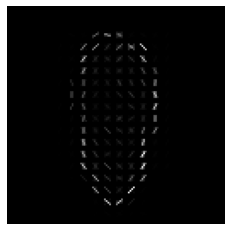

In [ ]:
from skimage.io import imread
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np

df_hog = pd.DataFrame()
for img_path in img_paths:
  img = cv.imread(img_path)
  RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  hist, hog_image = hog(RGB_img, orientations=8, pixels_per_cell=(7, 7), cells_per_block=(3, 3), visualize=True, transform_sqrt=False)

  _h = hist

  # hog_flat = hog_image.flatten()
  arr_length = len(hist)
  hist = hist.reshape((1, arr_length))
  # hog_flat = hog_flat.reshape((1, arr_length))
  df = pd.DataFrame(data=hist, index=[0], columns=map(str, range(arr_length)))
  df_hog = df_hog.append(df, ignore_index = True)

df_hog = df_hog.add_prefix('hog_')
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
print(hist.shape)

In [ ]:
_df = df_feature
_df = _df.join(df_hog)

In [ ]:
_df

,R_mean,G_mean,B_mean,R_std,G_std,B_std,R_skew,G_skew,B_skew,H_mean,...,hog_18422,hog_18423,hog_18424,hog_18425,hog_18426,hog_18427,hog_18428,hog_18429,hog_18430,hog_18431
0,5.580688,5.382568,5.201660,17.980515,17.501374,17.084410,-16.119703,-16.164455,-16.205113,5.190308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.412109,7.242004,7.214478,22.314999,21.942560,21.868892,-19.436366,-19.477100,-19.483676,8.324585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.755005,5.611389,5.585083,18.298654,17.953429,17.862815,-16.486055,-16.518202,-16.524077,9.112244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.328064,4.329041,4.246033,14.423013,14.426820,14.224941,-14.420815,-14.420637,-14.435738,1.820801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.016541,5.847290,5.735718,18.728592,18.391196,18.127959,-16.933405,-16.971012,-16.995716,7.053833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,28.393372,18.223938,10.083740,57.611609,38.711526,23.148802,-39.074780,-42.778773,-45.463137,9.745667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
646,25.942932,16.807922,10.322205,53.521495,36.929763,25.425229,-36.786260,-40.043714,-42.155055,7.456421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,22.772339,14.819275,9.520935,46.388195,32.985526,24.552336,-32.512221,-35.251232,-36.929398,7.334656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,31.645508,20.585327,13.413330,60.794343,41.597893,29.534791,-39.770518,-44.050197,-46.540786,8.575073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classification

## KNN

In [ ]:
X = _df
y = df_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

### K = 3

0.823076923076923
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9565    0.8462    0.8980        26
      Nabtat     0.6071    0.6538    0.6296        26
     Shaishe     0.8966    1.0000    0.9455        26
      Sugaey     0.6667    0.6154    0.6400        26

    accuracy                         0.8231       130
   macro avg     0.8254    0.8231    0.8226       130
weighted avg     0.8254    0.8231    0.8226       130



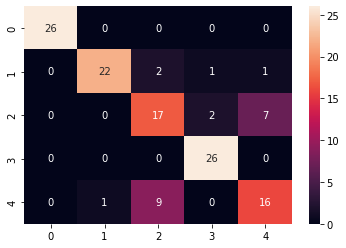

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train['label'])
predictions = neigh.predict(X_test)
print(neigh.score(X_test, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

### K = 5

0.823076923076923
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9583    0.8846    0.9200        26
      Nabtat     0.5926    0.6154    0.6038        26
     Shaishe     0.9286    1.0000    0.9630        26
      Sugaey     0.6400    0.6154    0.6275        26

    accuracy                         0.8231       130
   macro avg     0.8239    0.8231    0.8228       130
weighted avg     0.8239    0.8231    0.8228       130



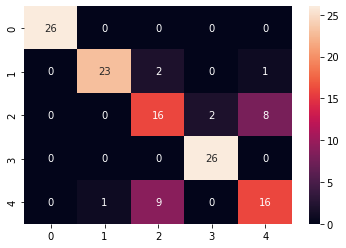

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train['label'])
predictions = neigh.predict(X_test)
print(neigh.score(X_test, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

### K = 7

0.8153846153846154
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9231    0.9231    0.9231        26
      Nabtat     0.6250    0.5769    0.6000        26
     Shaishe     0.8929    0.9615    0.9259        26
      Sugaey     0.6154    0.6154    0.6154        26

    accuracy                         0.8154       130
   macro avg     0.8113    0.8154    0.8129       130
weighted avg     0.8113    0.8154    0.8129       130



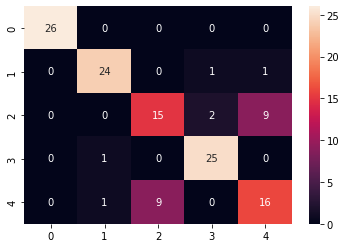

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train['label'])
predictions = neigh.predict(X_test)
print(neigh.score(X_test, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

## KNN with PCA as dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(100, random_state = 1)
X_pca = pca.fit_transform(_df)
y = df_label
print(X_pca.shape)
# print(pd.DataFrame(X_pca))

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=1)

(650, 100)


### K = 3

0.823076923076923
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9583    0.8846    0.9200        26
      Nabtat     0.5926    0.6154    0.6038        26
     Shaishe     0.9286    1.0000    0.9630        26
      Sugaey     0.6400    0.6154    0.6275        26

    accuracy                         0.8231       130
   macro avg     0.8239    0.8231    0.8228       130
weighted avg     0.8239    0.8231    0.8228       130



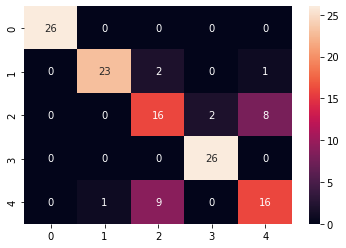

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_pca, y_train['label'])
predictions = neigh.predict(X_test_pca)
print(neigh.score(X_test_pca, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

### K = 5

0.7923076923076923
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9167    0.8462    0.8800        26
      Nabtat     0.5556    0.5769    0.5660        26
     Shaishe     0.8929    0.9615    0.9259        26
      Sugaey     0.6000    0.5769    0.5882        26

    accuracy                         0.7923       130
   macro avg     0.7930    0.7923    0.7920       130
weighted avg     0.7930    0.7923    0.7920       130



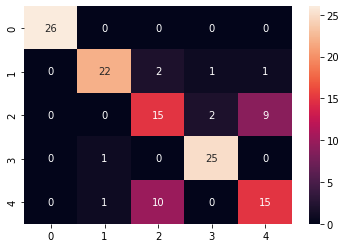

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_pca, y_train['label'])
predictions = neigh.predict(X_test_pca)
print(neigh.score(X_test_pca, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

### K = 7

0.8
              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        26
      Galaxy     0.9200    0.8846    0.9020        26
      Nabtat     0.5926    0.6154    0.6038        26
     Shaishe     0.8929    0.9615    0.9259        26
      Sugaey     0.5833    0.5385    0.5600        26

    accuracy                         0.8000       130
   macro avg     0.7978    0.8000    0.7983       130
weighted avg     0.7978    0.8000    0.7983       130



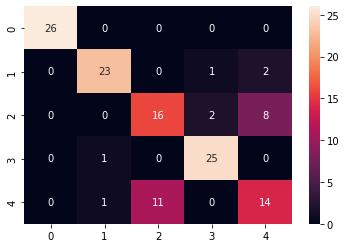

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train_pca, y_train['label'])
predictions = neigh.predict(X_test_pca)
print(neigh.score(X_test_pca, y_test))
print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt="d")

## KNN with BPSO as feature selection

### Binary PSO for feature selection; K = 3

In [43]:
class BPSO:
  def __init__(self, f_count, df_feature, df_label):
    # Feature count 
    self.f_count  = f_count
    # Actual Positions 
    self.pos_act  = []
    # Binary Positions
    self.position = []
    # Random Velocity
    self.velocity = []
    # best position 
    self.pos_best = []
    # Y actual 
    self.y_actual = []
    # Y test predicted 
    self.y_predict= []
    # Best Fit Accuracy, Recall, Precision
    self.fit_best = (-1, -1, -1)
    # Accuracy, Recall,Pprecsion 
    self.fitness  = (-1, -1, -1)
    # data 
    self.df_feature       = df_feature.copy()
    self.df_label         = df_label.copy()
    
    self.initialize(f_count)

  def initialize(self, f_count):
    self.f_count = f_count
    self.initalize_position(f_count)
    self.initialize_velocity(f_count)

  def initalize_position(self,f_count):
    self.pos_act = np.random.uniform(low=0, high=1, size=f_count).tolist()
    self.position = [1 if po > 0.5 else 0  for po in self.pos_act]
      
  def initialize_velocity(self, f_count):
    self.velocity = np.random.uniform(low=-1, high=1, size=f_count).tolist()

  def drop_columns(self, X):
    print(X.shape)
    print(self.position)
    drop_index = []
    for index, value in enumerate(self.position):
      if value == 0 :
        drop_index.append(index)
    _X = X.drop(X.columns[drop_index], axis = 1)
    return _X

  def classification_performance(self,y_actual, y_hat):       
    report = classification_report(y_actual, y_hat, output_dict=True)
    return (report['accuracy'], report['macro avg']['recall'], report['macro avg']['precision'])

  def process_data(self):
    X = self.df_feature
    y = self.df_label
    
    X = self.drop_columns(X)
    
    # Convert string label to decimal
    label = LabelEncoder()
    y = label.fit_transform(y['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    KNN = KNeighborsClassifier(n_neighbors=3)
    KNN.fit(X_train, y_train)
    
    y_pred = KNN.predict(X_test)
    y_pred_train = KNN.predict(X_train)
    
    class_acc = self.classification_performance(y_test, y_pred)
    
    self.y_actual = y_test
    self.y_predict = y_pred
      
    return class_acc

  def fitness_check(self,fitness, fit_best):
    is_fitness = False
    if fitness[0] > fit_best[0] or fitness[1] > fit_best[1] or fitness[2] > fit_best[2]:
      is_fitness = True
    return is_fitness

  def evaluate_fitness(self):
    self.fitness = self.process_data()
    if  self.fitness_check(self.fitness, self.fit_best):
      self.pos_best  = self.position.copy()
      self.fit_best = self.fitness
        
    print("Fitness: ")
    print(self.fitness)

  def update_velocity(self, pos_best_global):
    c1 = 1.4
    c2 = 1.4
    w  = 0.5

    for i in range(0, self.f_count):
      r1 = np.random.uniform(low=0, high=1, size=1)[0]
      r2 = np.random.uniform(low=0, high=1, size=1)[0]
      velocity_cog = c1*r1*(self.pos_best[i]-self.position[i])
      velocity_soc = c2*r2*(pos_best_global[i]-self.position[i])
      
      self.velocity[i]=w*self.velocity[i]+velocity_cog+velocity_soc

  def update_position(self):
    for i in range(0, self.f_count):
      self.pos_act[i] = self.pos_act[i] + self.velocity[i]
      if self.pos_act[i] > 1:
        self.pos_act[i] = 0.9 
      if self.pos_act[i] < 0 :
        self.pos_act[i] = 0.0
      self.position[i] = 1 if self.pos_act[i] > 0.5 else 0

In [44]:
def pso_calculate(f_count, df_feature, df_label):
  y_actual = []
  y_predict = []
  fitness_best_g = (-1, -1, -1)
  pos_fitness_g = []
  swarm = []
  no_population = 100
  
  for i in range(0,no_population):
    swarm.append(BPSO(f_count, df_feature, df_label))
  
  index = 0
  while index < 25:
    for pos in range(0, no_population):
      swarm[pos].evaluate_fitness()
      if swarm[pos].fitness_check(swarm[pos].fitness, fitness_best_g):
        pos_fitness_g = list(swarm[pos].position)
        fitness_best_g = (swarm[pos].fitness)
        y_actual = swarm[pos].y_actual
        y_predict = swarm[pos].y_predict
        
    for pos in range(0, no_population):
      swarm[pos].update_velocity(pos_fitness_g)
      swarm[pos].update_position()
    
    index+=1
  
  print('\n Final Solution:')
  print(pos_fitness_g)
  print(fitness_best_g)
  print(classification_report(y_actual, y_predict, digits=4))
  cm_2 = confusion_matrix(y_actual, y_predict)
  sns.heatmap(cm_2,annot=True,fmt="d")
  return pos_fitness_g

Streaming output truncated to the last 5000 lines.
(650, 100)
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Fitness: 
(0.9230769230769231, 0.9230769230769231, 0.9227236467236468)
(650, 100)
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Fitness: 
(0.9076923076923077, 0.9076923076923077, 0.9078021978021977)
(650, 100)
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 

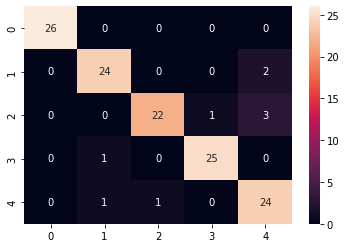

In [45]:
df = pd.DataFrame(X_pca)
best_pos = pso_calculate(df.shape[1], df, df_label)

In [46]:
count = 0
for x in best_pos:
  if x == 1:
    count = count + 1
print("Number of Features: ", count)

Number of Features:  58


### Binary PSO for feature selection; K = 5

In [47]:
class BPSO:
  def __init__(self, f_count, df_feature, df_label):
    # Feature count 
    self.f_count  = f_count
    # Actual Positions 
    self.pos_act  = []
    # Binary Positions
    self.position = []
    # Random Velocity
    self.velocity = []
    # best position 
    self.pos_best = []
    # Y actual 
    self.y_actual = []
    # Y test predicted 
    self.y_predict= []
    # Best Fit Accuracy, Recall, Precision
    self.fit_best = (-1, -1, -1)
    # Accuracy, Recall,Pprecsion 
    self.fitness  = (-1, -1, -1)
    # data 
    self.df_feature       = df_feature.copy()
    self.df_label         = df_label.copy()
    
    self.initialize(f_count)

  def initialize(self, f_count):
    self.f_count = f_count
    self.initalize_position(f_count)
    self.initialize_velocity(f_count)

  def initalize_position(self,f_count):
    self.pos_act = np.random.uniform(low=0, high=1, size=f_count).tolist()
    self.position = [1 if po > 0.5 else 0  for po in self.pos_act]
      
  def initialize_velocity(self, f_count):
    self.velocity = np.random.uniform(low=-1, high=1, size=f_count).tolist()

  def drop_columns(self, X):
    print(X.shape)
    print(self.position)
    drop_index = []
    for index, value in enumerate(self.position):
      if value == 0 :
        drop_index.append(index)
    _X = X.drop(X.columns[drop_index], axis = 1)
    return _X

  def classification_performance(self,y_actual, y_hat):       
    report = classification_report(y_actual, y_hat, output_dict=True)
    return (report['accuracy'], report['macro avg']['recall'], report['macro avg']['precision'])

  def process_data(self):
    X = self.df_feature
    y = self.df_label
    
    X = self.drop_columns(X)
    
    # Convert string label to decimal
    label = LabelEncoder()
    y = label.fit_transform(y['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    KNN = KNeighborsClassifier(n_neighbors=5)
    KNN.fit(X_train, y_train)
    
    y_pred = KNN.predict(X_test)
    y_pred_train = KNN.predict(X_train)
    
    class_acc = self.classification_performance(y_test, y_pred)
    
    self.y_actual = y_test
    self.y_predict = y_pred
      
    return class_acc

  def fitness_check(self,fitness, fit_best):
    is_fitness = False
    if fitness[0] > fit_best[0] or fitness[1] > fit_best[1] or fitness[2] > fit_best[2]:
      is_fitness = True
    return is_fitness

  def evaluate_fitness(self):
    self.fitness = self.process_data()
    if  self.fitness_check(self.fitness, self.fit_best):
      self.pos_best  = self.position.copy()
      self.fit_best = self.fitness
        
    print("Fitness: ")
    print(self.fitness)

  def update_velocity(self, pos_best_global):
    c1 = 1.4
    c2 = 1.4
    w  = 0.5

    for i in range(0, self.f_count):
      r1 = np.random.uniform(low=0, high=1, size=1)[0]
      r2 = np.random.uniform(low=0, high=1, size=1)[0]
      velocity_cog = c1*r1*(self.pos_best[i]-self.position[i])
      velocity_soc = c2*r2*(pos_best_global[i]-self.position[i])
      
      self.velocity[i]=w*self.velocity[i]+velocity_cog+velocity_soc

  def update_position(self):
    for i in range(0, self.f_count):
      self.pos_act[i] = self.pos_act[i] + self.velocity[i]
      if self.pos_act[i] > 1:
        self.pos_act[i] = 0.9 
      if self.pos_act[i] < 0 :
        self.pos_act[i] = 0.0
      self.position[i] = 1 if self.pos_act[i] > 0.5 else 0

In [48]:
def pso_calculate(f_count, df_feature, df_label):
  y_actual = []
  y_predict = []
  fitness_best_g = (-1, -1, -1)
  pos_fitness_g = []
  swarm = []
  no_population = 100
  
  for i in range(0,no_population):
    swarm.append(BPSO(f_count, df_feature, df_label))
  
  index = 0
  while index < 25:
    for pos in range(0, no_population):
      swarm[pos].evaluate_fitness()
      if swarm[pos].fitness_check(swarm[pos].fitness, fitness_best_g):
        pos_fitness_g = list(swarm[pos].position)
        fitness_best_g = (swarm[pos].fitness)
        y_actual = swarm[pos].y_actual
        y_predict = swarm[pos].y_predict
        
    for pos in range(0, no_population):
      swarm[pos].update_velocity(pos_fitness_g)
      swarm[pos].update_position()
    
    index+=1
  
  print('\n Final Solution:')
  print(pos_fitness_g)
  print(fitness_best_g)
  print(classification_report(y_actual, y_predict, digits=4))
  cm_2 = confusion_matrix(y_actual, y_predict)
  sns.heatmap(cm_2,annot=True,fmt="d")
  return pos_fitness_g

Streaming output truncated to the last 5000 lines.
(650, 100)
[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Fitness: 
(0.9230769230769231, 0.9230769230769231, 0.923901098901099)
(650, 100)
[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Fitness: 
(0.9230769230769231, 0.9230769230769231, 0.923901098901099)
(650, 100)
[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,

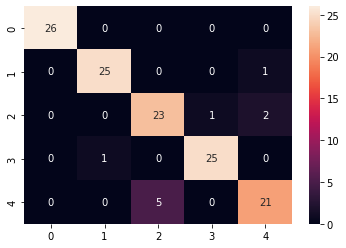

In [49]:
df = pd.DataFrame(X_pca)
best_pos = pso_calculate(df.shape[1], df, df_label)

In [50]:
count = 0
for x in best_pos:
  if x == 1:
    count = count + 1
print("Number of Features: ", count)

Number of Features:  55


### Binary PSO for feature selection; K = 7

In [56]:
class BPSO:
  def __init__(self, f_count, df_feature, df_label):
    # Feature count 
    self.f_count  = f_count
    # Actual Positions 
    self.pos_act  = []
    # Binary Positions
    self.position = []
    # Random Velocity
    self.velocity = []
    # best position 
    self.pos_best = []
    # Y actual 
    self.y_actual = []
    # Y test predicted 
    self.y_predict= []
    # Best Fit Accuracy, Recall, Precision
    self.fit_best = (-1, -1, -1)
    # Accuracy, Recall,Pprecsion 
    self.fitness  = (-1, -1, -1)
    # data 
    self.df_feature       = df_feature.copy()
    self.df_label         = df_label.copy()
    
    self.initialize(f_count)

  def initialize(self, f_count):
    self.f_count = f_count
    self.initalize_position(f_count)
    self.initialize_velocity(f_count)

  def initalize_position(self,f_count):
    self.pos_act = np.random.uniform(low=0, high=1, size=f_count).tolist()
    self.position = [1 if po > 0.5 else 0  for po in self.pos_act]
      
  def initialize_velocity(self, f_count):
    self.velocity = np.random.uniform(low=-1, high=1, size=f_count).tolist()

  def drop_columns(self, X):
    print(X.shape)
    print(self.position)
    drop_index = []
    for index, value in enumerate(self.position):
      if value == 0 :
        drop_index.append(index)
    _X = X.drop(X.columns[drop_index], axis = 1)
    return _X

  def classification_performance(self,y_actual, y_hat):       
    report = classification_report(y_actual, y_hat, output_dict=True)
    return (report['accuracy'], report['macro avg']['recall'], report['macro avg']['precision'])

  def process_data(self):
    X = self.df_feature
    y = self.df_label
    
    X = self.drop_columns(X)
    
    # Convert string label to decimal
    label = LabelEncoder()
    y = label.fit_transform(y['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    KNN = KNeighborsClassifier(n_neighbors=7)
    KNN.fit(X_train, y_train)
    
    y_pred = KNN.predict(X_test)
    y_pred_train = KNN.predict(X_train)
    
    class_acc = self.classification_performance(y_test, y_pred)
    
    self.y_actual = y_test
    self.y_predict = y_pred
      
    return class_acc

  def fitness_check(self,fitness, fit_best):
    is_fitness = False
    if fitness[0] > fit_best[0] or fitness[1] > fit_best[1] or fitness[2] > fit_best[2]:
      is_fitness = True
    return is_fitness

  def evaluate_fitness(self):
    self.fitness = self.process_data()
    if  self.fitness_check(self.fitness, self.fit_best):
      self.pos_best  = self.position.copy()
      self.fit_best = self.fitness
        
    print("Fitness: ")
    print(self.fitness)

  def update_velocity(self, pos_best_global):
    c1 = 1.4
    c2 = 1.4
    w  = 0.5

    for i in range(0, self.f_count):
      r1 = np.random.uniform(low=0, high=1, size=1)[0]
      r2 = np.random.uniform(low=0, high=1, size=1)[0]
      velocity_cog = c1*r1*(self.pos_best[i]-self.position[i])
      velocity_soc = c2*r2*(pos_best_global[i]-self.position[i])
      
      self.velocity[i]=w*self.velocity[i]+velocity_cog+velocity_soc

  def update_position(self):
    for i in range(0, self.f_count):
      self.pos_act[i] = self.pos_act[i] + self.velocity[i]
      if self.pos_act[i] > 1:
        self.pos_act[i] = 0.9 
      if self.pos_act[i] < 0 :
        self.pos_act[i] = 0.0
      self.position[i] = 1 if self.pos_act[i] > 0.5 else 0

In [57]:
def pso_calculate(f_count, df_feature, df_label):
  y_actual = []
  y_predict = []
  fitness_best_g = (-1, -1, -1)
  pos_fitness_g = []
  swarm = []
  no_population = 100
  
  for i in range(0,no_population):
    swarm.append(BPSO(f_count, df_feature, df_label))
  
  index = 0
  while index < 50:
    for pos in range(0, no_population):
      swarm[pos].evaluate_fitness()
      if swarm[pos].fitness_check(swarm[pos].fitness, fitness_best_g):
        pos_fitness_g = list(swarm[pos].position)
        fitness_best_g = (swarm[pos].fitness)
        y_actual = swarm[pos].y_actual
        y_predict = swarm[pos].y_predict
        
    for pos in range(0, no_population):
      swarm[pos].update_velocity(pos_fitness_g)
      swarm[pos].update_position()
    
    index+=1
  
  print('\n Final Solution:')
  print(pos_fitness_g)
  print(fitness_best_g)
  print(classification_report(y_actual, y_predict, digits=4))
  cm_2 = confusion_matrix(y_actual, y_predict)
  sns.heatmap(cm_2,annot=True,fmt="d")
  return pos_fitness_g

Streaming output truncated to the last 5000 lines.
(650, 100)
[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Fitness: 
(0.9230769230769231, 0.9230769230769231, 0.922934472934473)
(650, 100)
[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Fitness: 
(0.9230769230769231, 0.9230769230769231, 0.922934472934473)
(650, 100)
[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,

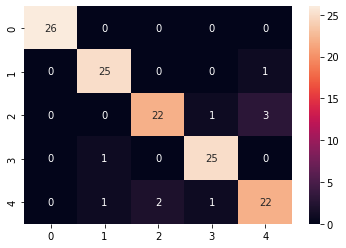

In [58]:
df = pd.DataFrame(X_pca)
best_pos = pso_calculate(df.shape[1], df, df_label)

In [59]:
count = 0
for x in best_pos:
  if x == 1:
    count = count + 1
print("Number of Features: ", count)

Number of Features:  49
